# Step 2: Perform coarse rigid registration

In [16]:
import neuroglancer
from phathom import plotting
import zarr
import os
import matplotlib.pyplot as plt
import numpy as np
from phathom.registration import coarse
from phathom.utils import pickle_save
import tifffile
from phathom.utils import pickle_load, read_voxel_size

In [12]:
viewer = neuroglancer.Viewer()
viewer

http://127.0.0.1:35347/v/13836af5b4829136b6d1bfa13910f2c578afd65c/

Use this in IPython to allow external viewing (from VM)
```
neuroglancer.set_server_bind_address(bind_address='192.168.158.128', bind_port=80)
```

In [13]:
working_dir = '/media/jswaney/Drive/Justin/marmoset'

In [20]:
fixed_path = 'round1/syto16.zarr/64_64_64'
moving_path = 'round2/syto16.zarr/64_64_64'
fixed_voxel_size = (1, 1, 2)
moving_voxel_size = (1, 1, 2)
downsample_factor = 64

fixed_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                     fixed_path))
moving_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                      moving_path))

fixed_down = zarr.load(fixed_store)
moving_down = zarr.load(moving_store)

print('Downsampled shapes:', fixed_down.shape, moving_down.shape)

plotting.plot_both(fixed_down, 
                   moving_down, 
                   viewer, 
                   normalization=4000,
                   fixed_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size),
                   moving_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size))

Downsampled shapes: (57, 141, 114) (71, 141, 87)


# Set a threshold for tissue foreground

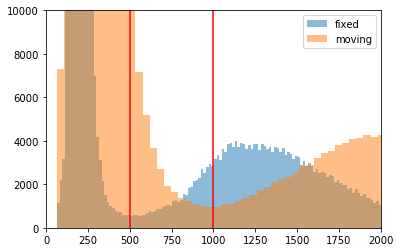

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


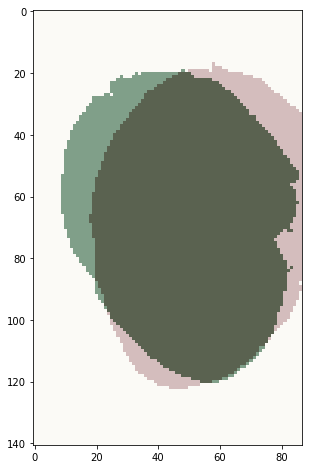

In [5]:
thresh_fixed = 500
thresh_moving = 1000

bins = 256
xmax = 2e3
ymax = 10000

plt.hist(fixed_down.ravel(), bins, alpha=0.5, label='fixed')
plt.hist(moving_down.ravel(), bins, alpha=0.5, label='moving')
plt.plot([thresh_fixed, thresh_fixed], [0, ymax], 'r-')
plt.plot([thresh_moving, thresh_moving], [0, ymax], 'r-')
plt.xlim([0, xmax])
plt.ylim([0, ymax])
plt.legend()
plt.show()

fixed_mask = (fixed_down > thresh_fixed)
moving_mask = (moving_down > thresh_moving)

plt.figure(figsize=(12, 8))
plt.imshow(fixed_mask[fixed_mask.shape[0] // 2], alpha=0.5, cmap='Reds')
plt.imshow(moving_mask[moving_mask.shape[0] // 2], alpha=0.5, cmap='Greens')
plt.legend()
plt.show()

In [6]:
optim_kwargs = {'niter': 10,
                't0': np.array([-1, 5, -15]),
                'theta0': np.array([-0.54, 0.29, -0.08]),
                's0': 1}
min_size = None
use_hull = False

threshold = [thresh_moving, thresh_fixed]

t_down, theta, center_down, s = coarse.coarse_registration(moving_down, 
                                                        fixed_down, 
                                                        threshold,
                                                        optim_kwargs,
                                                        min_size=min_size,
                                                        use_hull=use_hull)

basinhopping step 0: f 0.261566
basinhopping step 1: f 0.26238 trial_f 0.26238 accepted 1  lowest_f 0.261566
basinhopping step 2: f 0.263903 trial_f 0.263903 accepted 1  lowest_f 0.261566
basinhopping step 3: f 0.261355 trial_f 0.261355 accepted 1  lowest_f 0.261355
found new global minimum on step 3 with function value 0.261355
basinhopping step 4: f 0.261447 trial_f 0.261447 accepted 1  lowest_f 0.261355
adaptive stepsize: acceptance rate 0.800000 target 0.500000 new stepsize 0.111111 old stepsize 0.1
basinhopping step 5: f 0.261702 trial_f 0.261702 accepted 1  lowest_f 0.261355
basinhopping step 6: f 0.26138 trial_f 0.26138 accepted 1  lowest_f 0.261355
basinhopping step 7: f 0.261704 trial_f 0.261704 accepted 1  lowest_f 0.261355
basinhopping step 8: f 0.262038 trial_f 0.262038 accepted 1  lowest_f 0.261355
basinhopping step 9: f 0.262774 trial_f 0.262774 accepted 1  lowest_f 0.261355
adaptive stepsize: acceptance rate 0.900000 target 0.500000 new stepsize 0.123457 old stepsize 0.1

# Warp downsampled image

In [7]:
s, theta, t_down

(1.0138872328878725,
 array([-0.56238193,  0.24496881, -0.07573708]),
 array([  2.01692891,   5.02418633, -14.16782721]))

In [19]:
registered_down = coarse.rigid_warp(moving_down, 
                                    t_down, 
                                    theta,
                                    s,
                                    center_down, 
                                    fixed_down.shape)

plotting.plot_both(fixed_down, 
                   registered_down, 
                   viewer, 
                   normalization=3000,
                   fixed_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size),
                   moving_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size))

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/tornado/iostream.py", line 713, in _handle_events
    self._handle_write()
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/tornado/iostream.py", line 1063, in _handle_write
    self._write_buffer.advance(num_bytes)
  File "/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/tornado/iostream.py", line 184, in advance
    assert 0 < size <= self._

# Convert to fullres transformation

In [9]:
fixed_fullres_path = 'round1/syto16.zarr/1_1_1'
moving_fullres_path = 'round2/syto16.zarr/1_1_1'

fixed_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                             fixed_fullres_path))
moving_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                              moving_fullres_path))
fixed_img = zarr.open(fixed_fullres_store, mode='r')
moving_img = zarr.open(moving_fullres_store, mode='r')

true_factors = np.array(fixed_img.shape) / np.array(fixed_down.shape)
t, center = coarse._scale_rigid_params(t_down, 
                                          center_down,
                                          true_factors)

print('Fullres:', t, center)
print(fixed_img.shape)
print(fixed_down.shape)

Fullres: [ 127.38498407  321.40539529 -904.1310784 ] [ 2018.60540501  4194.25275517  2923.68065906]
(3600, 9020, 7275)
(57, 141, 114)


# Save the fullres transformation

In [10]:
rigid_path = 'rigid_transformation.pkl'

transformation_dict = {'t': t,
                       'theta': theta,
                       'center': center,
                       's': s}

pickle_save(os.path.join(working_dir, rigid_path), transformation_dict)

# Use Nuggt-align for get manual coarse alignment (optional)

If coarse alignment based on a rigid transformation is not adequate, then we can use nuggt to manually provide correspondences for an affine alignment, which contains more degrees of freedom for better coarse alignment. For this, we need to run nuggt-align to get point correspondences--we need 3D tiffs to do this, so we'll save them from our ZarrStack here.

In [5]:
fixed_path = 'round1/syto16.zarr/2_2_2'
moving_path = 'round2/syto16.zarr/2_2_2'
fixed_voxel_size = (1, 1, 2)
moving_voxel_size = (1, 1, 2)
downsample_factor = 2

fixed_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                     fixed_path))
moving_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                      moving_path))

fixed_down = zarr.load(fixed_store)
moving_down = zarr.load(moving_store)

fixed_down.shape

(289, 1181, 1420)

In [8]:
tifffile.imsave(os.path.join(working_dir, 'round1/syto16_2x.tif'), fixed_down, compress=1)
tifffile.imsave(os.path.join(working_dir, 'round2/syto16_2x.tif'), moving_down, compress=1)

Now we need to run `nuggt-align` with these tiffs to select corresponding points. Save the points file and read it here: